<font size="+3"><strong>3. Chi-square test</strong></font>

In the previous notebook, we identified a subset of applicants who don't complete the python quiz. Then we developed a null and alternative hypothesis that we want to test in an experiment.

In this notebook, we'll conduct our experiment. First, we'll determine how long we need to run our experiment in order to detect a significant difference between our control and treatment groups. Then we'll run our experiment and evaluate our results using a chi-square test.

In [ ]:
# Import libraries
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy
from pymongo.mongo_client import MongoClient
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower

# Preparing the Experiment

## Connect to Database



In [ ]:
client = MongoClient(uri)
db = client["ds-abtest"]
ds_app = db["ds-applicants"]

print("client:", type(client))
print("ds_app:", type(ds_app))

client: <class 'pymongo.mongo_client.MongoClient'>
ds_app: <class 'pymongo.collection.Collection'>


## Calculate Power



In [ ]:
chi_square_power = GofChisquarePower()
group_size = math.ceil(
    chi_square_power.solve_power(effect_size=0.5, alpha=0.05, power=0.8)
)
print("Group size:", group_size)
print("Total # of applicants needed:", group_size * 2)

Group size: 32
Total # of applicants needed: 64


The results here are telling us that if we want to detect an effect size of 0.5 we need a group size of about 32 people. Since our experiment has two conditions (treatment and control, or email and no email), that means we need a total of about 64 applicants in our experiment.

But what about detecting other effect sizes? If we needed to detect a *larger* effect size, we'd need *fewer* applicants. If we needed to detect a *smaller* effect size, we'd need *more* applicants. One way to visualize the relationship between effect size, statistical power, and number of applicants is to make a graph.

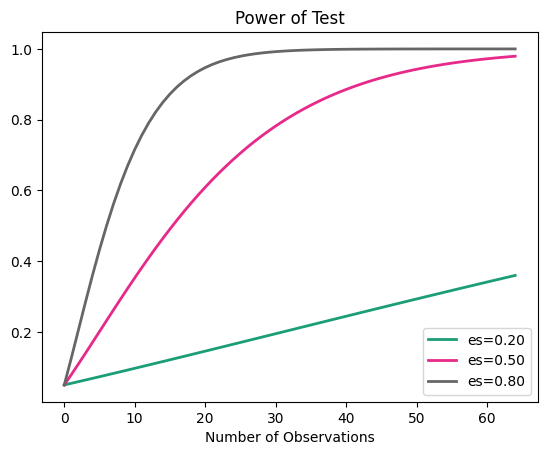

In [ ]:
n_observations = np.arange(0, group_size * 2 + 1)
effect_sizes = np.array([0.2, 0.5, 0.8])

# Plot power curve using `chi_square_power`
chi_square_power.plot_power(
    dep_var = "nobs",
    nobs = n_observations,
    effect_size = effect_sizes,
    alpha = 0.05,
    n_bins = 2
);

## Calculate Subjects per Day

In the previous notebook, we decided that our experiment would focus on the subset of applicants who don't take the python quiz immediately after creating an account. We know we need around 75 observations from this subset, but how long do we need to run our experiment for in order to get that number?

To answer that question, we first need to calculate how many such applicants open an account each day.

In [ ]:
result = ds_app.aggregate(
    [
        {"$match" : {"pythonQuiz":"incomplete"}},
        {
            "$group": {
                "_id": {"$dateTrunc": {"date":"$createdAt", "unit": "day"}},
                "count": {"$sum": 1}
                }
         }
    ]
)

print("result type:", type(result))

result type: <class 'pymongo.command_cursor.CommandCursor'>


Now we'll read our query result into a Series.

In [ ]:
no_quiz = (
    pd.DataFrame(result)
     .rename(columns={"_id":"date", "count":"new_users"})
     .set_index("date")
     .sort_index()
     .squeeze()
)

print("no_quiz type:", type(no_quiz))
print("no_quiz shape:", no_quiz.shape)
no_quiz.head()

no_quiz type: <class 'pandas.core.series.Series'>
no_quiz shape: (30,)


date
2022-06-01    20
2022-06-02     9
2022-06-03    12
2022-06-04    15
2022-06-05    11
Name: new_users, dtype: int64

Okay! Let's see what we've got here by creating a histogram.

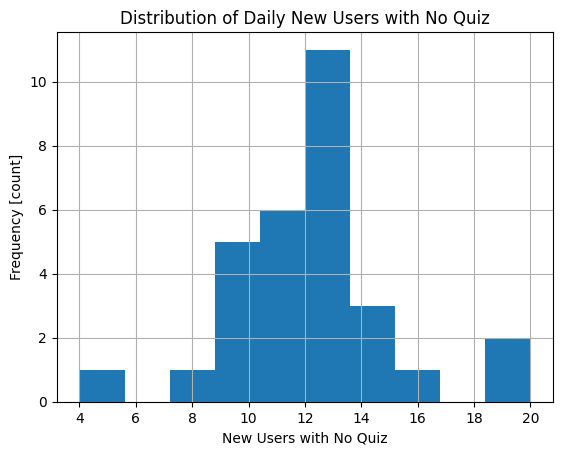

In [ ]:
# Create histogram of `no_quiz`
no_quiz.hist()
# Add axis labels and title
plt.xlabel("New Users with No Quiz")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Daily New Users with No Quiz");

In [ ]:
# Calculate the mean and standard deviation of the values in no_quiz
mean = no_quiz.describe()["mean"]
std = no_quiz.describe()["std"]
print("no_quiz mean:", mean)
print("no_quiz std:", std)

no_quiz mean: 12.133333333333333
no_quiz std: 3.170264139254595


In [ ]:
days = 7
sum_mean = mean * days
sum_std = std * np.sqrt(days)
print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

Mean of sum: 84.93333333333334
Std of sum: 8.3877305028539


With this new distribution, we want to know what the probability is that we'll have 65 or fewer no-quiz applicants after 7 days. We can calculate this using the **cumulative density function** or CDF. The CDF will give us the probability of having 65 or fewer no-quiz applicants, so we'll need to subtract our result from 1.

In [ ]:
prob_65_or_fewer = scipy.stats.norm.cdf(
    group_size * 2,
    loc = sum_mean,
    scale = sum_std
)
prob_65_or_greater =  1 - prob_65_or_fewer

print(
    f"Probability of getting 65+ no_quiz in {days} days:",
    round(prob_65_or_greater, 3),
)

Probability of getting 65+ no_quiz in 7 days: 0.994


# Running the Experiment

Okay, now we know how many applicants we need and what the timeframe needs to be. Let's actually run the experiment!

In [ ]:
exp = Experiment(repo=repo, db="abtest-data", collection="ds-applicants")
exp.reset_experiment()
result = exp.run_experiment(days=days)
print("result type:", type(result))
result

result type: <class 'dict'>


{'acknowledged': True, 'inserted_count': 1391}

# Evaluating Experiment Results

After all that work, the actual running of the experiment might seem a little anticlimactic. This is because we automated the process and are working with synthetic data. Let's look at our results?

## Get Data

First, get the data we need by finding just the people who were part of the experiment...

In [ ]:
result = ds_app.find({"inExperiment": True})
df = df = pd.DataFrame(result).dropna()

print("df type:", type(df))
print("df shape:", df.shape)
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (57, 12)


,_id,createdAt,firstName,lastName,email,birthday,gender,highestDegreeEarned,countryISO2,pythonQuiz,inExperiment,group
0,651c310e36eab9d3c09af3f0,2023-10-05 08:34:58,Robert,Herrera,robert.herrera36@gmall.com,1990-04-18,male,Master's degree,EG,complete,True,email (t)
1,651c310e36eab9d3c09af3f1,2023-10-04 00:25:41,Gilbert,Cothran,gilbert.cothran52@hotmeal.com,1998-05-05,male,Master's degree,PK,complete,True,email (t)
2,651c310e36eab9d3c09af3f2,2023-10-10 14:09:43,Craig,Mersch,craig.mersch58@microsift.com,1996-04-06,male,Bachelor's degree,IN,complete,True,email (t)
3,651c310e36eab9d3c09af3f3,2023-10-07 00:10:10,Crystal,Farr,crystal.farr2@microsift.com,1998-02-03,female,Master's degree,UG,complete,True,email (t)
4,651c310e36eab9d3c09af3f4,2023-10-05 21:11:08,Teodoro,Ephriam,teodoro.ephriam3@hotmeal.com,1991-10-25,male,Bachelor's degree,NG,complete,True,email (t)


## Build Contingency Table

Now that the results are in a DataFrame, we can start pulling apart what we found. Let's start by making a table showing how many people did and didn't complete the quiz across our two groups.

In [ ]:
data = pd.crosstab(
    index = df["group"],
    columns = df["pythonQuiz"],
    normalize = True
).round(3)
print("data type:", type(data))
print("data shape:", data.shape)
data

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 2)


pythonQuiz,complete,incomplete
group,,
email (t),0.105,0.404
no email (c),0.018,0.474


Just to make it easier to see, let's show the results in a side-by-side bar chart.

In [ ]:
def build_contingency_bar():
    # Create side-by-side bar chart
    fig = px.bar(
        data_frame = data,
        barmode = "group",
        title = "Python Quiz Completion by Group"
    )
    # Set axis labels
    fig.update_layout(
        xaxis_title = "Group",
        yaxis_title = "Frequency [count]",
        legend = {"title": "Python Quiz"}
    )
    return fig


build_contingency_bar().show()

Without doing anything else, we can see that people who got an email actually did complete the quiz more often than people who didn't. So can we conclude that, as a general rule, applicants who receive an email are more likely to complete quiz. No, not yet. After all, the difference we see could be due to chance.

In order to determine if this difference is more than random variation, we need to take our results, put them into a **contingency table**, and run a statistical test.

In [38]:
contingency_table = Table2x2(data.values)

print("contingency_table type:", type(contingency_table))
contingency_table.table_orig

contingency_table type: <class 'statsmodels.stats.contingency_tables.Table2x2'>


array([[0.105, 0.404],
       [0.018, 0.474]])

Now that we have our table, we can calculate what we would expect to see if there was no difference quiz completion between our two groups.

In [ ]:
# Calculate fitted values
contingency_table.fittedvalues

array([[0.06254446, 0.44645554],
       [0.06045554, 0.43154446]])

These are the counts, but what about probabilities?

In [ ]:
# Calculate independent joint probabilities
contingency_table.independence_probabilities.round(3)

array([[0.062, 0.446],
       [0.06 , 0.431]])

## Conduct Chi-Square Test

Here's where the rubber meets the road: all the previous calculations have shown us that some of the people who got an email went on to complete the quiz, but we don't know what might be driving that effect. After all, some people might be responding to getting an email, but others might have finished the quiz whether we emailed them or not. Either way, the effect we found could just as easily be due to chance as it could be a result of something we did. The only way to find out whether the result is due to chance is to calculate *statistical significance*.

There are several ways to do this, but since the rows and columns here are unordered (nominal factors), we can do a chi-square test.

In [ ]:
chi_square_test = contingency_table.test_nominal_association()

print("chi_square_test type:", type(chi_square_test))
print(chi_square_test)

chi_square_test type: <class 'statsmodels.stats.contingency_tables._Bunch'>
df          1
pvalue      0.7959825886822126
statistic   0.06684802017834289


The important part of that result is the *p-value*. We set our threshold for significance at 0.05 way back at the beginning, so, for our results to be statistically significant, the p-value needs to be less than or equal to 0.05. Our p-value is much higher than 0.05, which means that the difference we saw in our side-by-side bar graph is probably due to chance. In other words, it's noise, not signal. So we can't reject our null hypothesis.

What does this result mean? It means there may not be any difference between the groups, or that the difference is so small that we don't have the statistical power to detect it.

Since this is a simulated experiment, we can actually increase the power by re-running the experiment for a longer time. If we ran the experiment for 60 days, we might end up with a statistically-significant result.

However, there are two important things to keep in mind. First, just because a result is *statistically* significant doesn't mean that it's *practically* significant. A 1% increase in quiz completion may not be worth the time or resources needed to run an email campaign every day. Second, when the number of observations gets very large, any small difference is going to appear statistically significant. This increases the risk of a false positive — rejecting our null hypothesis when it's actually true.

Setting the issue of significance aside for now, there's one more calculation that can be helpful in sharing the results of an experiment: the odds ratio. In other words, how much more likely is someone in the treatment group to complete the quiz versus someone in the control group?

In [ ]:
odds_ratio = contingency_table.oddsratio.round(1)
print("Odds ratio:", odds_ratio)

Odds ratio: 6.8


The interpretation here is that for every 1 person who doesn't complete the quiz, about 6.8 people do. Keep in mind, though, that this ratio isn't actionable in the case of our experiment because our results weren't statistically significant.

The last thing we need to do is print all the values in our contingency table.

In [ ]:
summary = contingency_table.summary()
print("summary type:", type(summary))
summary

summary type: <class 'statsmodels.iolib.table.SimpleTable'>


,Estimate,SE,LCB,UCB,p-value
Odds ratio,6.844,,0.000,87072387.643,0.818
Log odds ratio,1.923,8.347,-14.435,18.282,0.818
Risk ratio,5.639,,0.000,25336050.845,0.825
Log risk ratio,1.730,7.816,-13.589,17.048,0.825
